In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
from scipy.optimize import minimize
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
import mmars

In [38]:
min_width, max_width, num_radars = 0, 0, 3
radar_models = [mmars.FmcwRadar(position=np.array([[pos_x,0]]), signalNoiseRatio=[10, 10], N_chirps=1) for pos_x in np.linspace(min_width, max_width, num_radars)]

In [39]:
T_frame = .1
target_model = mmars.Target(start_position=np.array([[0.001,5.001]]), start_velocity=1., T_total=10., T_frame=T_frame)
target_model.generate_trajectory(trajectory_type="sinusoidal")
target_ground_truth = target_model.get_trajectory()

In [40]:
mrblat_simulation = mmars.MRBLaT_Functions(radar_models[1], target_model)
mrblat_simulation.run()
mrblat_simulation.run_tracking()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001AE6FF1EA10> and <mmars.target.Target object at 0x000001AE710F0E10>


100%|██████████| 100/100 [00:00<00:00, 320.52it/s]


In [41]:
# HARDCODED MRBLaT
radar_model_01 = radar_models[0]
radar_model_02 = radar_models[1]
radar_model_03 = radar_models[2]

target_model = target_model

mrblat_simulation_01 = mmars.MRBLaT_Functions(radar_model_01, target_model)
mrblat_simulation_01.run()
mrblat_simulation_01_data = mrblat_simulation_01.get_data()
mrblat_simulation_02 = mmars.MRBLaT_Functions(radar_model_02, target_model)
mrblat_simulation_02.run()
mrblat_simulation_02_data = mrblat_simulation_02.get_data()
mrblat_simulation_03 = mmars.MRBLaT_Functions(radar_model_03, target_model)
mrblat_simulation_03.run()
mrblat_simulation_03_data = mrblat_simulation_03.get_data()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001AE6FF1DD10> and <mmars.target.Target object at 0x000001AE710F0E10>


100%|██████████| 100/100 [00:00<00:00, 340.87it/s]


Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001AE6FF1EA10> and <mmars.target.Target object at 0x000001AE710F0E10>


100%|██████████| 100/100 [00:00<00:00, 293.39it/s]


Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001AE71106850> and <mmars.target.Target object at 0x000001AE710F0E10>


100%|██████████| 100/100 [00:00<00:00, 373.18it/s]


In [ ]:
PHI_bar = np.array([[target_ground_truth[0][0], target_ground_truth[1][0],target_ground_truth[2][0], target_ground_truth[3][0]]]) # First position, (x,y) and (vx,vy) at t=0
PHI_bbar = 0.01*np.eye(4)[np.newaxis,:,:] # Initial guess for the covariance matrix of the target model. The position (x,y) and the variance (eps_barbar_x, eps_barbar_y) at t=0
PHI_bar_no_msg_parsing = PHI_bar
PHI_bbar_no_msg_parsing = PHI_bbar
EPSILON_bar_01 = EPSILON_bar_02 = EPSILON_bar_03 = PHI_bar# np.array([[PHI_bar[0][0], PHI_bar[0][1], 0, 0]])
EPSILON_bbar_01 = EPSILON_bbar_02 = EPSILON_bbar_03 = PHI_bbar# np.array([[[1e-1, 0, 0, 0],[0, 1e-1, 0, 0],[0, 0, 1e-10, 0],[0, 0, 0, 1e-10]]])
bound = [(-100,100), (0.1,100), (0.01, 10), (0.01, 10)]
N_ite = 1

T = np.array([[1,0,T_frame,0],[0,1,0,T_frame],[0,0,1,0],[0,0,0,1]])
T_T = T.T
T_inv = np.linalg.pinv(T)
G = np.array([[T_frame**2/2, 0, 0, 0],[0, T_frame**2/2, 0, 0],[0, 0, T_frame, 0],[0, 0, 0, T_frame]])
G_inv_T = np.linalg.pinv(G).T
G_inv = np.linalg.pinv(G)
lambda_a = np.eye(4)*.01

N_estimates = 1

regularisation = 0

for frame_idx in tqdm(range(1,mrblat_simulation_02.get_number_of_frames())):
    x0 = [EPSILON_bar_01[-1][0], EPSILON_bar_01[-1][1], EPSILON_bbar_01[-1][0,0], EPSILON_bbar_01[-1][1,1]]
    data_fourier = np.fft.fft(mrblat_simulation_01_data[frame_idx],axis=-1).flatten()
    D_KL_res_01 = minimize(mrblat_simulation_01.D_KL, x0=x0, bounds=bound, args=(data_fourier, EPSILON_bar_01[-1][0], EPSILON_bar_01[-1][1], (1,1,1,1), False), method='nelder-mead', options={'maxiter': 100})

    EPSILON_bar_01 = np.vstack((EPSILON_bar_01, np.array([D_KL_res_01.x[0], D_KL_res_01.x[1], regularisation, regularisation])))
    EPSILON_bbar_01 = np.vstack((EPSILON_bbar_01, np.array([[[D_KL_res_01.x[2], 0, 0, 0],[0, D_KL_res_01.x[3], 0, 0],[0, 0, regularisation, 0],[0, 0, 0, regularisation]]])))

    PHI_bar = np.vstack((PHI_bar, np.array([[D_KL_res_01.x[0], D_KL_res_01.x[1], 0, 0]]) ))
    PHI_bbar = np.vstack((PHI_bbar, np.array([[D_KL_res_01.x[2], 0, 0, 0],[0,D_KL_res_01.x[3],0,0],[0,0,0.0,0],[0,0,0,0]])[np.newaxis,:,:] ))
    PHI_bar_no_msg_parsing = np.vstack((PHI_bar_no_msg_parsing, np.array([[D_KL_res_01.x[0], D_KL_res_01.x[1], 0, 0]]) ))
    PHI_bbar_no_msg_parsing = np.vstack((PHI_bbar_no_msg_parsing, np.array([[D_KL_res_01.x[2], 0, 0, 0],[0,D_KL_res_01.x[3],0,0],[0,0,0,0],[0,0,0,0]])[np.newaxis,:,:] ))

    if N_estimates < 200:
        N_estimates += 1

    N_estimates_range = range(len(PHI_bar)-N_estimates-1, len(PHI_bar)-1)

    for ite in range(N_ite):
        for n_estimates in N_estimates_range:
            if (n_estimates > 0) and (n_estimates < N_estimates-1):
                eps_np1_to_n_mean = T_inv@PHI_bar[n_estimates+1] 
                esp_nm1_to_n_mean = T@PHI_bar[n_estimates-1] 
                eps_np1_to_n_cov = T_T@G_inv_T@lambda_a@G_inv@T 
                esp_nm1_to_n_cov = G_inv_T@lambda_a@G

                PHI_bbar[n_estimates] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])
                    +np.linalg.pinv(eps_np1_to_n_cov)
                    +np.linalg.pinv(esp_nm1_to_n_cov)
                    )
                
                PHI_bar[n_estimates] = PHI_bbar[n_estimates]@(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])@EPSILON_bar_01[n_estimates] 
                    +np.linalg.pinv(eps_np1_to_n_cov)@eps_np1_to_n_mean
                    +np.linalg.pinv(esp_nm1_to_n_cov)@esp_nm1_to_n_mean
                    )
                
            elif (n_estimates < N_estimates-1):
                eps_np1_to_n_mean = T_inv@PHI_bar[n_estimates+1]
                eps_np1_to_n_cov = T_T@G_inv_T@lambda_a@G_inv@T 

                PHI_bbar[n_estimates] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])
                    +np.linalg.pinv(eps_np1_to_n_cov) 
                    )
                PHI_bar[n_estimates] = PHI_bbar[n_estimates]@(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])@EPSILON_bar_01[n_estimates] 
                    +np.linalg.pinv(eps_np1_to_n_cov)@eps_np1_to_n_mean 
                    )
            elif (n_estimates > 0):
                print("ffff")
                esp_nm1_to_n_mean = T@PHI_bar[n_estimates-1]
                esp_nm1_to_n_cov = G_inv_T@lambda_a@G

                PHI_bbar[n_estimates] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])
                    +np.linalg.pinv(esp_nm1_to_n_cov) 
                    )
                PHI_bar[n_estimates] = PHI_bbar[n_estimates]@(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])@EPSILON_bar_01[n_estimates] 
                    +np.linalg.pinv(esp_nm1_to_n_cov)@esp_nm1_to_n_mean 
                    )
            
        if len(PHI_bar) > 1:
            alpha = len(PHI_bar) + 1 
            beta = 0
            for _n_ in N_estimates_range:
                beta += np.linalg.norm(G_inv@(PHI_bar[_n_]-T@PHI_bar[_n_-1]))**2 + G_inv@(PHI_bbar[_n_] + T@PHI_bbar[_n_-1]@T_T)@G_inv_T
            lambda_a = np.linalg.pinv(beta/alpha)


  0%|          | 0/99 [00:00<?, ?it/s]

 22%|██▏       | 22/99 [00:20<01:12,  1.06it/s]


KeyboardInterrupt: 

(26, 4)


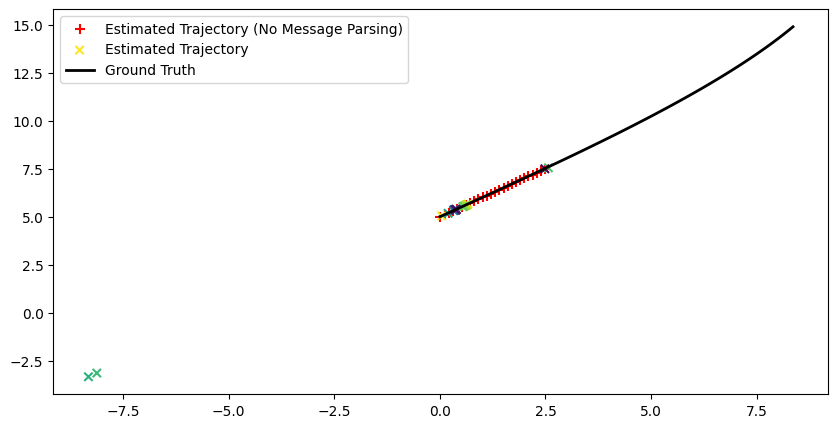

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(PHI_bar_no_msg_parsing[:,0], PHI_bar_no_msg_parsing[:,1], label='Estimated Trajectory (No Message Parsing)', marker = '+', s=50, color='red')#, cmap='viridis', c=np.linspace(0,1,len(PHI_bar_no_msg_parsing[:,0])))
ax.scatter(PHI_bar[:,0], PHI_bar[:,1], label='Estimated Trajectory', cmap='viridis', marker='x', c=np.linspace(1,0,len(PHI_bar[:,0])))#, s=50, color='blue')#
ax.plot(target_ground_truth[0], target_ground_truth[1], label='Ground Truth', color='black', linewidth=2)
ax.legend()

print(PHI_bar.shape)

In [ ]:
PHI_bar

array([[ 4.75820803e+000,  1.52003462e+001,  2.56712918e-010,
         2.56736022e-010],
       [ 6.71959574e+000,  1.62792729e+001,  1.14994376e-001,
         1.55898972e-001],
       [ 6.19969712e+000,  1.61326531e+001,  2.60237315e-001,
         2.81859773e-001],
       [ 5.53588244e+000,  1.55023667e+001,  3.84623996e-001,
         3.97218240e-001],
       [ 4.77452858e+000,  1.47547808e+001,  5.09354137e-001,
         5.12864000e-001],
       [ 3.92599954e+000,  1.39117299e+001,  6.36068735e-001,
         6.29802157e-001],
       [ 2.95378352e+000,  1.29443892e+001,  7.56755594e-001,
         7.39976524e-001],
       [ 1.92829991e+000,  1.19250222e+001,  8.61011061e-001,
         8.33165272e-001],
       [-1.14408564e+062, -1.14408564e+062,  7.62723763e+062,
         7.62723763e+062],
       [-7.00916922e+098, -7.00916922e+098,  4.67277948e+099,
         4.67277948e+099],
       [-2.57231567e+099, -2.57231567e+099,  2.02639574e+100,
         2.02639574e+100],
       [-8.34913954e+